# Random Dot Product Graphs (RDPG)

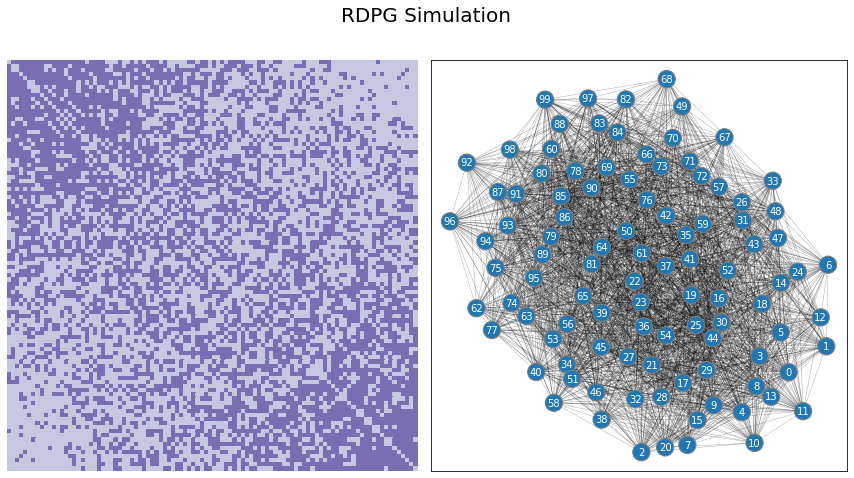

In [1]:
import numpy as np
from graspologic.simulations import rdpg
from graphbook_code import draw_multiplot

n = 100  # the number of nodes in our network

# design the latent position matrix X according to 
# the rules we laid out previously
X = np.zeros((n,2))
for i in range(0, n):
    X[i,:] = [(n - i)/n, i/n]

from graspologic.simulations import rdpg
from graphbook_code import draw_multiplot

A = rdpg(X, directed=False, loops=False)
draw_multiplot(A, title="RDPG Simulation");

## Latent Positions

Let's imagine that we have a network which follows the *a priori* Stochastic Block Model. To make this example a little bit more concrete, let's borrow the code example from above. The nodes of our network represent each of the $100$ students in our network. The node assignment vector represents which of the two schools eaach student attends, where the first $50$ students attend the first school, and the second $50$ students attend school $2$. Remember that $\tau$ and $B$ look like:

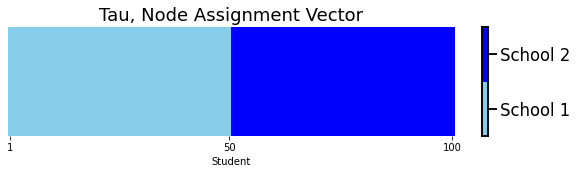

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib

def plot_tau(tau, title="", xlab="Node"):
    cmap = matplotlib.colors.ListedColormap(["skyblue", 'blue'])
    fig, ax = plt.subplots(figsize=(10,2))
    with sns.plotting_context("talk", font_scale=1):
        ax = sns.heatmap((tau - 1).reshape((1,tau.shape[0])), cmap=cmap,
                        ax=ax, cbar_kws=dict(shrink=1), yticklabels=False,
                        xticklabels=False)
        ax.set_title(title)
        cbar = ax.collections[0].colorbar
        cbar.set_ticks([0.25, .75])
        cbar.set_ticklabels(['School 1', 'School 2'])
        ax.set(xlabel=xlab)
        ax.set_xticks([.5,49.5,99.5])
        ax.set_xticklabels(["1", "50", "100"])
        cbar.ax.set_frame_on(True)
    return

n = 100  # number of students

# tau is a column vector of 150 1s followed by 50 2s
# this vector gives the school each of the 300 students are from
tau = np.vstack((np.ones((int(n/2),1)), np.full((int(n/2),1), 2)))

plot_tau(tau, title="Tau, Node Assignment Vector",
        xlab="Student")

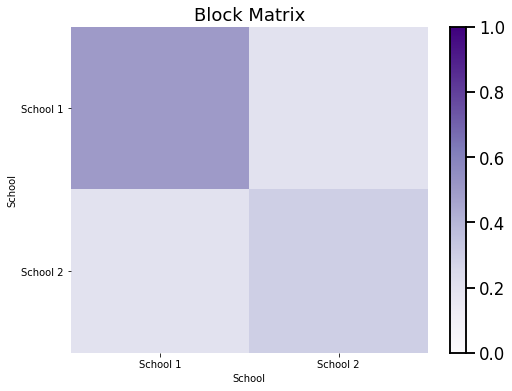

In [3]:
K = 2  # 2 communities in total
# construct the block matrix B as described above
B = [[0.5, 0.2], [0.2, 0.3]]

def plot_block(X, title="", blockname="School", blocktix=[0.5, 1.5],
               blocklabs=["School 1", "School 2"]):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    with sns.plotting_context("talk", font_scale=1):
        ax = sns.heatmap(X, cmap="Purples",
                        ax=ax, cbar_kws=dict(shrink=1), yticklabels=False,
                        xticklabels=False, vmin=0, vmax=1)
        ax.set_title(title)
        cbar = ax.collections[0].colorbar
        ax.set(ylabel=blockname, xlabel=blockname)
        ax.set_yticks(blocktix)
        ax.set_yticklabels(blocklabs)
        ax.set_xticks(blocktix)
        ax.set_xticklabels(blocklabs)
        cbar.ax.set_frame_on(True)
    return

plot_block(B, title="Block Matrix")
plt.show()

Are there any other ways to describe this scenario, other than using both $\vec\tau$ and $B$?

What if we were to look at the probabilities for *every* pair of edges? Remember, for a given $\vec\tau$ and $B$, that a network which is SBM can be generated using the approach that, given that $\tau_i = \ell$ and $\tau_j = k$, each edge $(i, j)$ comes down to a coin flip, where the edge exists if the coin lands on heads with probability $b_{\tau_i \tau_j}$ or does not exist if the coin lands on tails with probability $1- b_{\tau_i \tau_j}$. However, there's another way we could write down this generative model. Suppose we had a $n \times n$ probability matrix, where for every $j > i$:
\begin{align*}
    p_{ji} = p_{ij}, p_{ij} = \begin{cases}
        b_{11} & \tau_i = 1, \tau_j = 1 \\
        b_{12} & \tau_i = 1, \tau_j = 2 \\
        b_{22} & \tau_i = 2, \tau_j = 1
    \end{cases}
\end{align*}
This matrix $P$ with entries $p_{ij}$ is the probability matrix associated with the SBM. Simply put, this matrix describes the probability of each edge $(i,j)$ existing. What does $P$ look like?

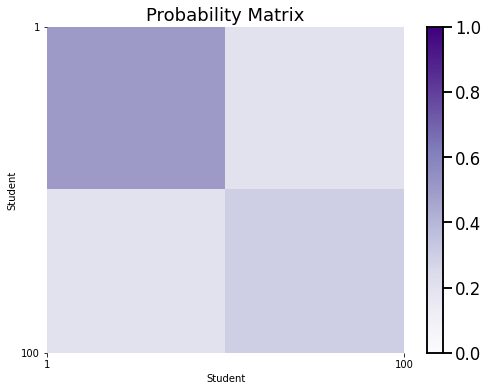

In [4]:
def plot_prob(X, title="", nodename="Student", nodetix=None,
             nodelabs=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    with sns.plotting_context("talk", font_scale=1):
        ax = sns.heatmap(X, cmap="Purples",
                        ax=ax, cbar_kws=dict(shrink=1), yticklabels=False,
                        xticklabels=False, vmin=0, vmax=1)
        ax.set_title(title)
        cbar = ax.collections[0].colorbar
        ax.set(ylabel=nodename, xlabel=nodename)
        if (nodetix is not None) and (nodelabs is not None):
            ax.set_yticks(nodetix)
            ax.set_yticklabels(nodelabs)
            ax.set_xticks(nodetix)
            ax.set_xticklabels(nodelabs)
        cbar.ax.set_frame_on(True)
    return

P = np.zeros((n,n))
P[0:50,0:50] = .5
P[50:100, 50:100] = .3
P[0:50,50:100] = .2
P[50:100,0:50] = .2

ax = plot_prob(P, title="Probability Matrix", nodetix=[0,100],
              nodelabs=["1", "100"])
plt.show()

As we can see, $P$ captures a similar modular structure to the actual adjacency matrix corresponding to the SBM network. When we say this network is *modular*, we mean that it looks block-y, in that there are clusters of edges sharing a similar probability. Also, $P$ captures the probability of connections between each pair of students. Indeed, it is the case that $P$ contains the information of both $\vec\tau$ and $B$. This means that we can write down a generative model by specifying *only* $P$, and we no longer need to specify $\vec\tau$ and $B$ at all. 

What is so special about this formulation of the SBM problem? As it turns out, for a *positive semi-definite* probability matrix $P$, $P$ can be decomposed using a matrix $X$, where $P = X X^\top$. We will call a single row of $X$ the vector $\vec x_i$. Remember, using this expression, each entry $p_{ij}$ is the product $\vec x_i^\top \vec x_j$, for all $i, j$. Like $P$, $X$ has $n$ rows, each of which corresponds to a single node in our network. However, the special property of $X$ is that it doesn't *necessarily* have $n$ columns: rather, $X$ often will have many fewer columns than rows. For instance, with $P$ as above, there in fact exists an $X$ with just $2$ columns that can be used to describe $P$. This matrix $X$ will be called the **latent position matrix**, and each row $\vec x_i$ will be called the **latent position of a node**. For each pair of nodes $(i, j)$, we have a unique coin which has a $\vec x_i^\top \vec x_j$ chance of landing on heads, and a $1 - \vec x_i^\top \vec x_j$ chance of landing on tails. For the edge between nodes $i$ and $j$, this edge exists if the coin lands on heads, or does not exist if the coin lands on tails.

Now, your next thought might be that this requires a *lot* more space to represent an SBM network, and you'd be right: $\vec \tau$ has $n$ entries, and $B$ has $K \times K$ entries, where $K$ is typically much smaller than $n$. On the other hand, in this formulation, $P$ has $\binom{n}{2}$ entries, which is much bigger than $n + K \times K$ (since $K$ is usually much smaller than $n$). The advantage is that under this formulation, $P$ doesn't need to have this rigorous modular structure characteristic of SBM networks, and can look a *lot* more interesting. As we will see in later chapters, this network representation will prove extremely flexible for allowing us to capture networks that are fairly complex. Further, we can also perform analysis on the matrix $X$ itself, which will prove very useful for estimation of SBMs.



### Code Examples

We will let $X$ be a little more complex than in our preceding example. Our $X$ will produce a $P$ that still *somewhat* has a modular structure, but not quite as much as before. Let's assume that we have $100$ people who live along a very long road that is $100$ miles long, and each person is $1$ mile apart. The nodes of our network represent the people who live along our assumed street. If two people are closer to one another, it might make sense to think that they have a higher probability of being friends. If two people are neighbors, we think that they will have a very high probability of being friends (almost $1$) and when people are very far apart, we think that they will have a very low probability of being friends (almost $0$). What could we use for $X$?

Remember that the latent positions for each node $i$ are denoted by the vector $\vec x_i$. One possible approach would be to let each $\vec x_i$ be defined as follows:
\begin{align*}
    \vec x_i = \begin{bmatrix}
        \frac{100 - i}{100} \\
        \frac{i}{100}
    \end{bmatrix}
\end{align*}
For instance, $\vec x_1 = \begin{bmatrix}1 \\ 0\end{bmatrix}$, and $\vec x_{100} = \begin{bmatrix} 0 \\ 1\end{bmatrix}$. Note that:
\begin{align*}
p_{1,100} = \vec x_1^\top \vec x_j = 1 \cdot 0 + 0 \cdot 1 = 0
\end{align*}
What happens in between?

Let's consider another person, person $30$. Note that person $30$ lives closer to person $1$ than to person $100$.  Here, $\vec x_{30} = \begin{bmatrix} \frac{7}{10}\\ \frac{3}{10}\end{bmatrix}$. This gives us that:
\begin{align*}
p_{1,30} &= \vec x_1^\top \vec x_{30} = \frac{7}{10}\cdot 1 + 0 \cdot \frac{3}{10} = \frac{7}{10} \\
p_{30, 100} &= \vec x_{30}^\top x_{100} = \frac{7}{10} \cdot 0 + \frac{3}{10} \cdot 1 = \frac{3}{10}
\end{align*}
So this means that person $1$ and person $30$ have a $70\%$ probability of being friends, but person $30$ and $100$ have onl6 a $30\%$ probability of being friends.

Intuitively, it seems like our probability matrix $P$ will capture the intuitive idea we described above. First, we'll take a look at $X$, and then we'll look at $P$:

In [5]:
n = 100  # the number of nodes in our network

# design the latent position matrix X according to 
# the rules we laid out previously
X = np.zeros((n,2))
for i in range(0, n):
    X[i,:] = [(n - i)/n, i/n]

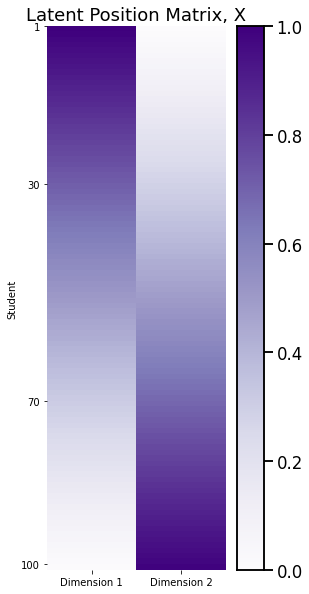

In [6]:
def plot_lp(X, title="", ylab="Student"):
    fig, ax = plt.subplots(figsize=(4, 10))
    
    with sns.plotting_context("talk", font_scale=1):
        ax = sns.heatmap(X, cmap="Purples",
                        ax=ax, cbar_kws=dict(shrink=1), yticklabels=False,
                        xticklabels=False)
        ax.set_title(title)
        cbar = ax.collections[0].colorbar
        ax.set(ylabel=ylab)
        ax.set_yticks([0, 29, 69, 99])
        ax.set_yticklabels(["1", "30", "70", "100"])
        ax.set_xticks([.5, 1.5])
        ax.set_xticklabels(["Dimension 1", "Dimension 2"])
        cbar.ax.set_frame_on(True)
    return

plot_lp(X, title="Latent Position Matrix, X")

The latent position matrix $X$ that we plotted above is $n \times d$ dimensions. There are a number of approaches, other than looking at a heatmap of $X$, with which we can visualize $X$ to derive insights as to its structure. When $d=2$, another popular visualization is to look at the latent positions, $\vec x_i$, as individual points in $2$-dimensional space. This will give us a scatter plot of $n$ points, each of which has two coordinates. Each point is the latent position for a single node:

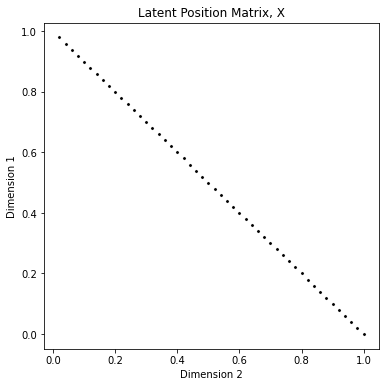

In [7]:
def plot_latents(latent_positions, title=None, labels=None, **kwargs):
    fig, ax = plt.subplots(figsize=(6, 6))
    if ax is None:
        ax = plt.gca()
    ss = 2*np.arange(0, 50)
    plot = sns.scatterplot(x=latent_positions[ss, 0], y=latent_positions[ss, 1], hue=labels, 
                           s=10, ax=ax, palette="Set1", color='k', **kwargs)
    ax.set_title(title)
    ax.set(ylabel="Dimension 1", xlabel="Dimension 2")
    ax.set_title(title)
    return plot

# plot
plot_latents(X, title="Latent Position Matrix, X");

The above scatter plot has been subsampled to show only every $2^{nd}$ latent position, so that the individual $2$-dimensional latent positions are discernable. Due to the way we constructed $X$, the scatter plot would otherwise appear to be a line (due to points overlapping one another). The reason that the points fall along a vertical line when plotted as a vector is due to the method we used to construct entries of $X$, described above. Next, we will look at the probability matrix:

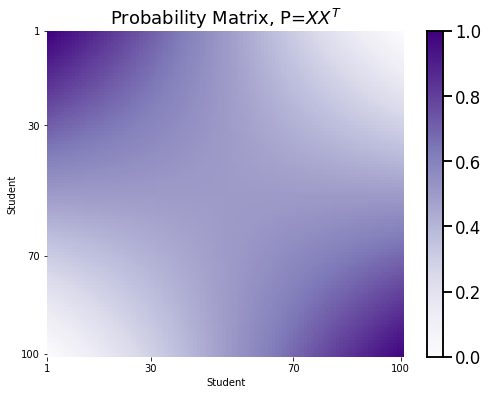

In [8]:
plot_prob(X.dot(X.transpose()), title="Probability Matrix, P=$XX^T$",
         nodelabs=["1", "30", "70", "100"], nodetix=[0,29,69,99])

Finally, we will sample an RDPG:

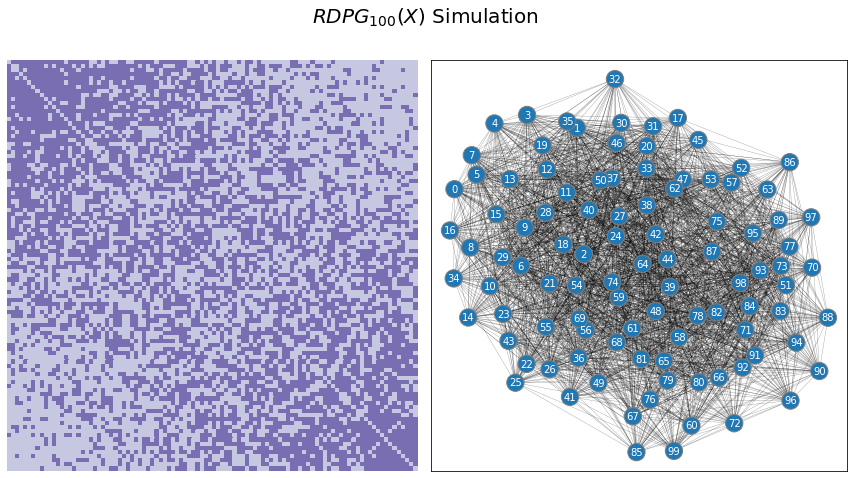

In [9]:
from graspologic.simulations import rdpg
from graphbook_code import draw_multiplot

# sample an RDPG with the latent position matrix
# created above
A = rdpg(X, loops=False, directed=False)

# and plot it
ax = draw_multiplot(A, title="$RDPG_{100}(X)$ Simulation")